In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
from torch.nn.utils.rnn import pad_sequence

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heyouzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/heyouzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#find whether GPU is available
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS device is available")
else:
    print ("MPS device not found.")

MPS device is available


EDA

In [6]:
imdb_csv = 'IMDB Dataset.csv'
df = pd.read_csv(imdb_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y) #stratify=y ensures that the class distribution of y (the target variable) is the same in both y_train and y_test
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


In [8]:
y_train=[1  if x=="positive" else 0 for x in y_train]
y_test=[1  if x=="positive" else 0 for x in y_test]

## data preprocessing

In this section, we first use NTLK to tokenize the sentences, and then pad or truncate the sentences.

In [9]:
# Tokenization,padding, and truncating
global max_sentence_length
max_sentence_length = 100

def preprocess(text):
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words("english")) #delete stop words
    tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words] #here we delete all non alphabet or numerical tokens

    if len(tokens) >= max_sentence_length:
        tokens = tokens[:max_sentence_length]
    else:
        tokens += ['<pad>'] * (max_sentence_length - len(tokens))

    return tokens

In [10]:
# Apply tokenization and preprocess to all texts
train_texts = [preprocess(text) for text in x_train]
test_texts = [preprocess(text) for text in x_test]

# Build vocabulary
flattened_train_texts = [word for sublist in train_texts for word in sublist]
word_counter = Counter(flattened_train_texts)
vocab = {word: idx for idx, (word, _) in enumerate(word_counter.most_common(), 2)}
vocab['<unk>'] = 0 #this is for unknow word
vocab['<pad>'] = 1 #this is for padding position

In [11]:
# Convert tokens to indices
x_train_indices = [[vocab.get(word, vocab['<unk>']) for word in preprocess(text)] for text in x_train]
x_test_indices = [[vocab.get(word, vocab['<unk>']) for word in preprocess(text)] for text in x_test] #since we built vocabulary dictionary on the train dataset, words from test dataset may not be in the list. If so, we use unknown to replace it.

# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [12]:
# Define a PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = CustomDataset(x_train_indices, y_train_tensor)
test_dataset = CustomDataset(x_test_indices, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=lambda batch: (pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True, padding_value=0), torch.tensor([item[1] for item in batch])))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=lambda batch: (pad_sequence([torch.tensor(item[0]) for item in batch], batch_first=True, padding_value=0), torch.tensor([item[1] for item in batch])))

## Bidirectional LSTM

Then we start to train the model

In [13]:
# Define the model with an embedding layer and a bidirectional LSTM
class BiLSTMWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(BiLSTMWithEmbedding, self).__init__()
        #After you've tokenized your text and assigned each word an integer index, the next step is to transform these integer indices into dense vectors using an embedding layer. Each word index is essentially used as a lookup key in the embedding layer, and the layer returns the corresponding vector representation for that word.
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #transform each word into vector with embedding dimension
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim, #the number of hidden units or neurons in the LSTM layer
            num_layers=num_layers, #a stacked LSTM with multiple layers
            bidirectional=bidirectional, #whether the lstm is bidirectional
            dropout=dropout, #Dropout can be applied to the recurrent connections by randomly setting a fraction of the hidden units to zero during each time step.
            batch_first=True #If set to True, the input tensors are expected to have the shape (batch_size, seq_len, input_size)
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim) #the output of lstm in each time stamp is the hidden state
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text)

        lstm_out, _ = self.lstm(embedded)

        # Concatenate the last hidden states from both directions
        hidden = self.dropout(torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1))
        #During the training phase, the dropout layer randomly sets a fraction of the input units (neurons) to zero with a specified probability (p).
        logits = self.fc(hidden)
        logits=torch.sigmoid(logits) #Since this is a binary classification problem, we use sigmoid activation function
        return logits

# Instantiate the model
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
num_layers = 2
bidirectional = True
dropout = 0.5

stackedbilstmmodel = BiLSTMWithEmbedding(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional,dropout)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(stackedbilstmmodel.parameters(), lr=0.001)


In [14]:
stackedbilstmmodel = stackedbilstmmodel.to(mps_device)

In [15]:
# Training loop
epochs = 7

trainloss=[]
testloss=[]
testaccuracy=[]

for epoch in range(epochs):
    stackedbilstmmodel.train()
    total_loss=0
    for batch in train_loader:
        X_batch, y_batch = batch
        y_batch = y_batch.float()  # Ensure labels are floats
        X_batch, y_batch =X_batch.to(mps_device), y_batch.to(mps_device)
        optimizer.zero_grad()
    
        predictions = stackedbilstmmodel(X_batch).squeeze(1)
        

        loss = criterion(predictions, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = total_loss / len(train_loader)
    trainloss.append(average_loss)
    print("*********")
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {average_loss}')

    # Evaluation on the test set
    stackedbilstmmodel.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        total_val_loss=0
        for batch in test_loader:
            X_batch, y_batch = batch
            y_batch = y_batch.float()  # Ensure labels are floats
            X_batch, y_batch =X_batch.to(mps_device), y_batch.to(mps_device)
            predictions = stackedbilstmmodel(X_batch).squeeze(1)
            # Calculate the number of correct predictions (assuming binary classification)
            predicted_labels = ( torch.round(predictions.squeeze()) >=0.5).float()
            correct_predictions += (predicted_labels == y_batch).sum().item()
            total_samples += y_batch.size(0)
            total_val_loss+=loss.item()

        accuracy = correct_predictions / total_samples
        testaccuracy.append(accuracy)
        average_loss = total_val_loss / len(test_loader)
        testloss.append(average_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {average_loss}, Test Accuracy: {accuracy * 100:.2f}%')
        print("*********")

*********
Epoch 1/7, Training Loss: 0.6923072054862976
Epoch 1/7, Test Loss: 0.7256650924682617, Test Accuracy: 51.83%
*********
*********
Epoch 2/7, Training Loss: 0.6914461329460144
Epoch 2/7, Test Loss: 0.6629374027252197, Test Accuracy: 58.09%
*********
*********
Epoch 3/7, Training Loss: 0.6665212011814118
Epoch 3/7, Test Loss: 0.5844694375991821, Test Accuracy: 70.75%
*********
*********
Epoch 4/7, Training Loss: 0.6434713652133942
Epoch 4/7, Test Loss: 0.6246778964996338, Test Accuracy: 79.19%
*********
*********
Epoch 5/7, Training Loss: 0.603864732003212
Epoch 5/7, Test Loss: 0.5358812808990479, Test Accuracy: 76.62%
*********
*********
Epoch 6/7, Training Loss: 0.5944140457153321
Epoch 6/7, Test Loss: 0.5643318891525269, Test Accuracy: 78.50%
*********
*********
Epoch 7/7, Training Loss: 0.5735676704645157
Epoch 7/7, Test Loss: 0.5131840705871582, Test Accuracy: 83.25%
*********


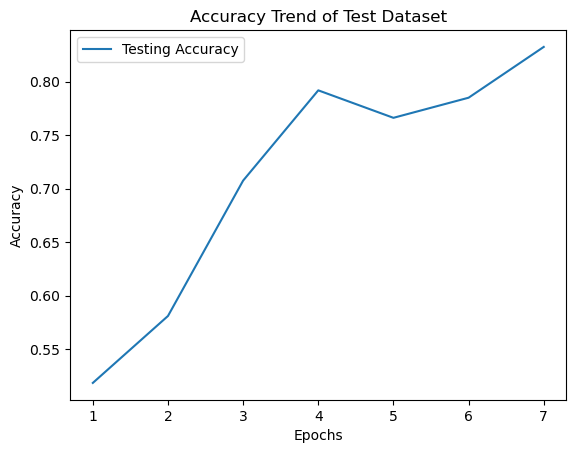

In [22]:
plt.plot([i+1 for i in range(epochs)],testaccuracy, label='Testing Accuracy')
plt.title('Accuracy Trend of Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

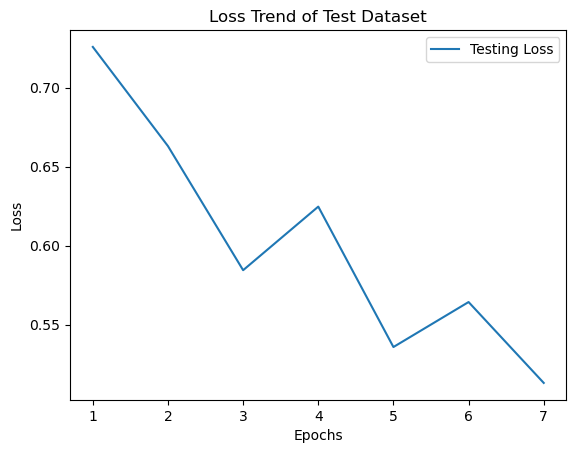

In [25]:
plt.plot([i+1 for i in range(epochs)],testloss, label='Testing Loss')
plt.title('Loss Trend of Test Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

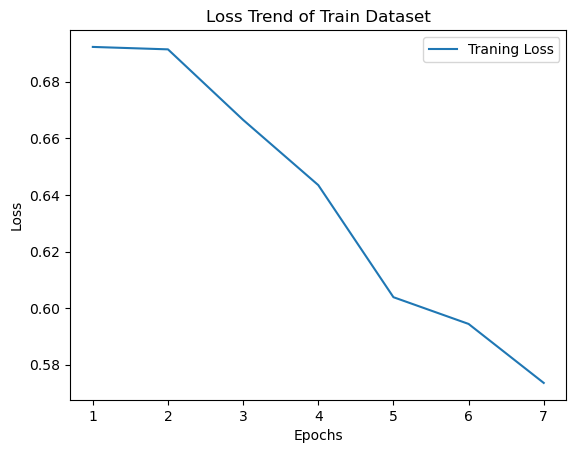

In [26]:
plt.plot([i+1 for i in range(epochs)],trainloss, label='Traning Loss')
plt.title('Loss Trend of Train Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()